In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from biodatatools.utils.common import json_load
from mphelper import ProcessWrapPool
from biodata.delimited import DelimitedReader, DelimitedWriter
import subprocess
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import pybedtools
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import mpmath as mp
import itertools
from pathlib import Path

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [4]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_d2 = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"

# Data preparation

In [ ]:
# https://github.com/xqwen/torus/
# TORUS expects all input files are gzipped.

## eQTL summary statistics

### Get relevant tissues

In [5]:
# All available eQTL tissues
# gsutil -u dotted-guru-385617 ls gs://gtex-resources/GTEx_Analysis_v8_QTLs/GTEx_Analysis_v8_EUR_eQTL_all_associations/ > /fs/cbsuhy01/storage/yc2553/yc2553/databases/eQTLs/GTEx/filenames.txt

df = pd.read_table(f"{PROJECT_DIR_d}eQTLs/GTEx/filenames.txt", header=None)
eTissues = set([t.split("/")[-1].split(".")[0] for t in df[0]])
len(eTissues), eTissues

(49,
 {'Adipose_Subcutaneous',
  'Adipose_Visceral_Omentum',
  'Adrenal_Gland',
  'Artery_Aorta',
  'Artery_Coronary',
  'Artery_Tibial',
  'Brain_Amygdala',
  'Brain_Anterior_cingulate_cortex_BA24',
  'Brain_Caudate_basal_ganglia',
  'Brain_Cerebellar_Hemisphere',
  'Brain_Cerebellum',
  'Brain_Cortex',
  'Brain_Frontal_Cortex_BA9',
  'Brain_Hippocampus',
  'Brain_Hypothalamus',
  'Brain_Nucleus_accumbens_basal_ganglia',
  'Brain_Putamen_basal_ganglia',
  'Brain_Spinal_cord_cervical_c-1',
  'Brain_Substantia_nigra',
  'Breast_Mammary_Tissue',
  'Cells_Cultured_fibroblasts',
  'Cells_EBV-transformed_lymphocytes',
  'Colon_Sigmoid',
  'Colon_Transverse',
  'Esophagus_Gastroesophageal_Junction',
  'Esophagus_Mucosa',
  'Esophagus_Muscularis',
  'Heart_Atrial_Appendage',
  'Heart_Left_Ventricle',
  'Kidney_Cortex',
  'Liver',
  'Lung',
  'Minor_Salivary_Gland',
  'Muscle_Skeletal',
  'Nerve_Tibial',
  'Ovary',
  'Pancreas',
  'Pituitary',
  'Prostate',
  'Skin_Not_Sun_Exposed_Suprapubic',

In [6]:
# PRO-cap tissues

cdict = json_load(f"{PROJECT_DIR_d2}PROcap/metainfo/color_codes.json")
pTissues = ["_".join(t.split(" ")) for t in cdict if t != "Other"] + ["Non_tissue_specific"]

In [7]:
# Focus on relevant tissues

tissue_mapping = defaultdict(list)
for t in pTissues[:-1]:
	if t in eTissues:
		tissue_mapping[t].append(t)
	elif t == "Blood":
		tissue_mapping[t].append("Whole_Blood")
	elif t == "Muscle":
		tissue_mapping[t].append("Muscle_Skeletal")
	elif t == "Large_intestine":
		tissue_mapping[t].extend(["Colon_Sigmoid", "Colon_Transverse"])
	elif t == "Small_intestine":
		tissue_mapping[t].append("Small_Intestine_Terminal_Ileum")
	elif t == "Heart":
		tissue_mapping[t].extend(["Heart_Atrial_Appendage", "Heart_Left_Ventricle"])
	elif t == "Adrenal_gland":
		tissue_mapping[t].append("Adrenal_Gland")
	elif t == "Breast":
		tissue_mapping[t].append("Breast_Mammary_Tissue")
	elif t == "Brain":
		tissue_mapping[t].extend([t for t in eTissues if "Brain" in t])

In [8]:
results = []
for t in pTissues[:-1]:
	results.append([t, ", ".join(tissue_mapping[t])])
df = pd.DataFrame(results, columns=["PRO-cap tissues", "GTEx tissues"])
df

,PRO-cap tissues,GTEx tissues
0,Blood,Whole_Blood
1,Lymph_node,
2,Spleen,Spleen
3,Brain,"Brain_Hypothalamus, Brain_Cerebellum, Brain_Putamen_basal_ganglia, Brain_Anterior_cingulate_cortex_BA24, Brain_Amygdala, Brain_Caudate_basal_ganglia, Brain_Spinal_cord_cervical_c-1, Brain_Cerebellar_Hemisphere, Brain_Cortex, Brain_Hippocampus, Brain_Substantia_nigra, Brain_Frontal_Cortex_BA9, Brain_Nucleus_accumbens_basal_ganglia"
4,Muscle,Muscle_Skeletal
5,Liver,Liver
6,Pancreas,Pancreas
7,Large_intestine,"Colon_Sigmoid, Colon_Transverse"
8,Small_intestine,Small_Intestine_Terminal_Ileum
9,Heart,"Heart_Atrial_Appendage, Heart_Left_Ventricle"


In [11]:
outputfile = f"{PROJECT_DIR_d2}PROcap/metainfo/GTEx_PROcap_tissue_mapping.txt"
df.to_csv(outputfile, sep="\t", index=False)

In [9]:
eTissues_included = [t2 for t in tissue_mapping for t2 in tissue_mapping[t]]
len(eTissues_included)

28

### Reformat summary statistics

In [ ]:
# Get full summary statistics from from Google cloud
# https://console.cloud.google.com/storage/browser/gtex-resources/GTEx_Analysis_v8_QTLs/GTEx_Analysis_v8_EUR_eQTL_all_associations

In [10]:
# Check the content of original file
# hg38, 1-based
# tss_distance: SNP position - TSS position
# slope: Coefficient for the SNP genotype in the linear model
# slope_se: Standard error of the slope

! zcat {PROJECT_DIR_d}eQTLs/GTEx/Breast_Mammary_Tissue.allpairs.txt.gz | head -n 3

gene_id	variant_id	tss_distance	ma_samples	ma_count	maf	pval_nominal	slope	slope_se
ENSG00000227232.5	chr1_13550_G_A_b38	-16003	8	8	0.010101	0.663501	-0.14507	0.333127
ENSG00000227232.5	chr1_14671_G_C_b38	-14882	8	8	0.010101	0.88755	-0.0447646	0.316323

gzip: stdout: Broken pipe


In [ ]:
# The required input format for TORUS

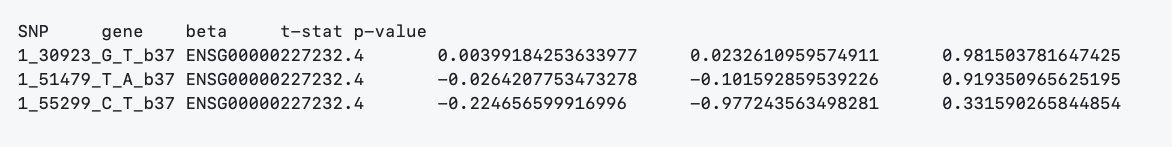

In [27]:
# Reformat the summary statistics for TORUS

def reformat_sumstats(inputfile, outputfile):
	with DelimitedWriter(outputfile) as dw:
		dw.write(["SNP", "gene", "beta", "t-stat", "p-value"])
		with DelimitedReader(inputfile) as dr:
			for cols in dr:
				if cols[0] == "gene_id":
					continue
				gene, snp, pvalue, beta, se = cols[0], cols[1], cols[-3], cols[-2], cols[-1]
				tstat = float(beta)/float(se)
				dw.write([snp, gene, beta, tstat, pvalue])

In [29]:
pwpool = ProcessWrapPool(10)

for k in eTissues_included:
	inputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.allpairs.txt.gz"
	outputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.sumstats.gz"
	pwpool.run(reformat_sumstats, args=[inputfile, outputfile])

In [174]:
len(pwpool.finished_tasks)

28

In [175]:
pwpool.close()

## SNP map files

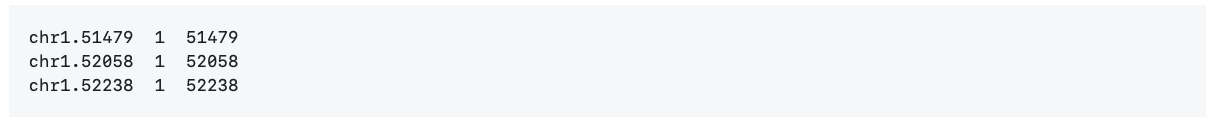

In [25]:
def get_snpmap(inputfile, outputfile):
	snps = set()
	with DelimitedWriter(outputfile) as dw:
		with DelimitedReader(inputfile) as dr:
			for cols in dr:
				if cols[0] == "gene_id":
					continue
				snp = cols[1]
				if snp in snps:
		            continue
				chrom, pos = snp.split("_")[:2]
				dw.write([snp, chrom, pos])
				snps.add(snp)

In [72]:
pwpool = ProcessWrapPool(10)

for k in eTissues_included:
	inputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.allpairs.txt.gz"
	outputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.snp.map.gz"
	pwpool.run(get_snpmap, args=[inputfile, outputfile])

In [86]:
len(pwpool.finished_tasks)

28

In [85]:
pwpool.close()

## Gene map files

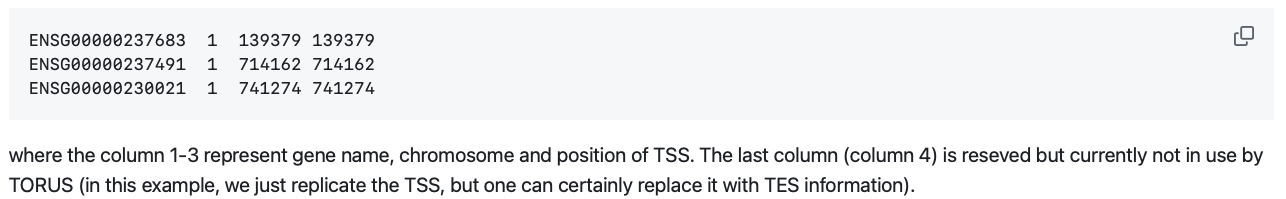

In [63]:
def get_genemap(inputfile, outputfile):
	genes = set()
	with DelimitedWriter(outputfile) as dw:
		with DelimitedReader(inputfile) as dr:
			for cols in dr:
				if cols[0] == "gene_id":
					continue
				gene, snp, tss_distance = cols[:3]
				if gene in genes:
					continue
				chrom, pos = snp.split("_")[:2]
				# 1-based
				tss = int(pos) - int(tss_distance)
				dw.write([gene, chrom, tss, tss])
				genes.add(gene)

In [87]:
pwpool = ProcessWrapPool(10)

for k in eTissues_included:
	inputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.allpairs.txt.gz"
	outputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.gene.map.gz"
	pwpool.run(get_genemap, args=[inputfile, outputfile])

In [89]:
len(pwpool.finished_tasks)

28

In [90]:
pwpool.close()

In [11]:
# Check the output

! zcat {PROJECT_DIR_d}eQTLs/GTEx/Breast_Mammary_Tissue.gene.map.gz | head -n 10

ENSG00000227232.5	chr1	29553	29553
ENSG00000268903.1	chr1	135895	135895
ENSG00000269981.1	chr1	137965	137965
ENSG00000241860.6	chr1	173862	173862
ENSG00000279457.4	chr1	195411	195411
ENSG00000228463.9	chr1	297502	297502
ENSG00000237094.11	chr1	501617	501617
ENSG00000225972.1	chr1	629062	629062
ENSG00000225630.1	chr1	629640	629640
ENSG00000237973.1	chr1	631074	631074

gzip: stdout: Broken pipe


In [12]:
# https://gtexportal.org/home/releaseInfoPage
# GTEx v8 --> GENCODE v26
# gtex-resources/GENCODE/gencode.v26.GRCh38.genes.stranded.bed

inputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/GENCODE_gencode.v26.GRCh38.genes.stranded.bed"
df = pd.read_table(inputfile, header=None)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,11868,14409,DDX11L1,1000,+,11868,14409,.,4,"359,109,78,1189,","0,744,1106,1352,",ENSG00000223972.5
1,chr1,14403,29570,WASH7P,1000,-,14403,29570,.,11,"98,34,152,159,198,136,137,147,99,154,37,","0,601,1392,2203,2454,2829,3202,3511,3864,10334,15130,",ENSG00000227232.5


In [64]:
# 0-based

df[df[12].isin(["ENSG00000241860.6", "ENSG00000237973.1"])]

,0,1,2,3,4,5,6,7,8,9,10,11,12
13,chr1,141473,173862,RP11-34P13.13,1000,-,141473,173862,.,10,"1538,3322,65,529,59,66,158,216,132,110,","0,4912,14293,22789,24410,26626,27136,27575,31083,32279,",ENSG00000241860.6
33,chr1,631073,632616,MTCO1P12,1000,+,631073,632616,.,1,"1543,","0,",ENSG00000237973.1


In [13]:
for k in eTissues_included:
	print(k, len(pd.read_table(f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.gene.map.gz")))

Whole_Blood 20314
Spleen 25478
Brain_Hypothalamus 25095
Brain_Cerebellum 25460
Brain_Putamen_basal_ganglia 23803
Brain_Anterior_cingulate_cortex_BA24 24341
Brain_Amygdala 24068
Brain_Caudate_basal_ganglia 24717
Brain_Spinal_cord_cervical_c-1 24668
Brain_Cerebellar_Hemisphere 25143
Brain_Cortex 24848
Brain_Hippocampus 24419
Brain_Substantia_nigra 24043
Brain_Frontal_Cortex_BA9 24675
Brain_Nucleus_accumbens_basal_ganglia 24889
Muscle_Skeletal 21030
Liver 22261
Pancreas 22614
Colon_Sigmoid 24482
Colon_Transverse 25378
Small_Intestine_Terminal_Ileum 26181
Heart_Atrial_Appendage 23193
Heart_Left_Ventricle 21352
Adrenal_Gland 23819
Lung 26094
Breast_Mammary_Tissue 25848
Ovary 25324
Testis 35006


## SNP annotation file

In [ ]:
# The annotation file uses a header to specify the number and the nature (categorical or continuous) of the anntations. 
# The first column with the header "SNP" represents the SNP name. The following columns represent specific annotations. For categorical/discrete annotations, the header should alwasy have a suffix "_d"; whereas for continuous annotations, the header should ends with "_c".

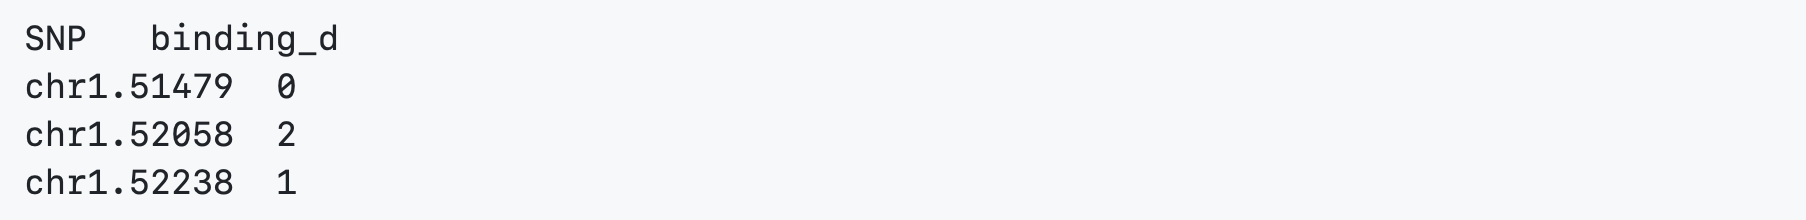

In [10]:
# Get bed file for SNP position for follow-up intersection with TRE annotation

def get_snp_bed(inputfile, outputfile):
	with DelimitedWriter(outputfile) as dw:
		with DelimitedReader(inputfile) as dr:
			for cols in dr:
				snp, chrom, pos = cols
				dw.write([chrom, int(pos)-1, pos, snp])

In [97]:
pwpool = ProcessWrapPool(10)

for k in eTissues_included:
	inputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.snp.map.gz"
	outputfile = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.snp.bed"
	pwpool.run(get_snp_bed, args=[inputfile, outputfile])

In [99]:
len(pwpool.finished_tasks)

28

In [100]:
pwpool.close()

In [14]:
# Check the output

! head {PROJECT_DIR_d}eQTLs/GTEx/Breast_Mammary_Tissue.snp.bed -n 3

chr1	13549	13550	chr1_13550_G_A_b38
chr1	14670	14671	chr1_14671_G_C_b38
chr1	14676	14677	chr1_14677_G_A_b38


In [16]:
# Same bed files used for annotation in "1-1.GWAS_LDSC_annot.ipynb"

p = "divergent"
ds = ["distal", "proximal"]
cutoff = 0.05
extension = 1000
outdir = f"{PROJECT_DIR_o}LDSC/annots/{cutoff}_{extension}"

In [12]:
# Generate annotation file for each sample

def get_annotations(d, k):
	b1 = pybedtools.BedTool(f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.snp.bed")
	all_snps = set([i.fields[3] for i in b1])

	# TREs from which tissue contain a given variant
	annots = defaultdict(set)
	for t in pTissues:
		b2 = pybedtools.BedTool(f"{outdir}{p}_{d}_{t}.bed")
		overlap = b1.intersect(b2, u=True)
		for i in overlap:
			annots[i.fields[3]].add(t)

	outputfile = f"{PROJECT_DIR_o}torus/{d}_{k}_annot.txt.gz"
	with DelimitedWriter(outputfile) as dw:	
		dw.write(["SNP"] + [f"{t}.{d}_d" for t in pTissues])
		for snp in all_snps:
			# Not found in any tissues
			if snp not in annots:
				dw.write([snp] + [0]*len(pTissues))
			else:
				dw.write([snp] + [1 if t in annots[snp] else 0 for t in pTissues])

In [13]:
pwpool = ProcessWrapPool(10)

for d, k in itertools.product(ds, eTissues_included):
	pwpool.run(get_annotations, args=[d, k])

In [20]:
# 28*2

len(pwpool.finished_tasks)

56

In [21]:
pwpool.close()

# eQTL enrichment

## Run torus

In [17]:
# With both snp_map and gene_map files specified, torus will control for SNP distance to gene TSS.

script = "/home/yc2553/slurm/torus/torus.sh"
for d, k in itertools.product(ds, eTissues_included):
	sumstats = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.sumstats.gz"
	snp_map = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.snp.map.gz"
	gene_map = f"{PROJECT_DIR_d}eQTLs/GTEx/{k}.gene.map.gz"
	annots = f"{PROJECT_DIR_o}torus/{d}_{k}_annot.txt.gz"
	outputfile = f"{PROJECT_DIR_o}torus/{d}_{k}_enrichment.txt"
	print(" ".join(["sbatch", script, sumstats, snp_map, gene_map, annots, outputfile]))

sbatch /home/yc2553/slurm/torus/torus.sh /fs/cbsuhy02/storage/yc2553/yc2553/databases/eQTLs/GTEx/Whole_Blood.sumstats.gz /fs/cbsuhy02/storage/yc2553/yc2553/databases/eQTLs/GTEx/Whole_Blood.snp.map.gz /fs/cbsuhy02/storage/yc2553/yc2553/databases/eQTLs/GTEx/Whole_Blood.gene.map.gz /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/torus/distal_Whole_Blood_annot.txt.gz /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/torus/distal_Whole_Blood_enrichment.txt
sbatch /home/yc2553/slurm/torus/torus.sh /fs/cbsuhy02/storage/yc2553/yc2553/databases/eQTLs/GTEx/Spleen.sumstats.gz /fs/cbsuhy02/storage/yc2553/yc2553/databases/eQTLs/GTEx/Spleen.snp.map.gz /fs/cbsuhy02/storage/yc2553/yc2553/databases/eQTLs/GTEx/Spleen.gene.map.gz /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/torus/distal_Spleen_annot.txt.gz /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/torus/distal_Spleen_enrichment.txt
sbatch /home/yc2553/slurm/torus/torus.sh /fs/cbsu

In [18]:
# Check the output
# The first column represents the annotation name and its corresponding level (for a categorical variable). The second column is the point estimate (MLE) of the log odds ratio. Columns 3-4 represent the 95% confidence interval for the corresponding point estimate.

inputfile = f"{PROJECT_DIR_o}torus/{d}_{k}_enrichment.txt"
df = pd.read_table(inputfile, header=None, delim_whitespace=True, index_col=0)
df

/tmp/ipykernel_2573849/3255664338.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(inputfile, header=None, delim_whitespace=True, index_col=0)


,1,2,3
0,,,
Intercept,-9.946,-9.951,-9.941
Blood.proximal.1,1.517,1.308,1.726
Lymph_node.proximal.1,0.767,0.520,1.015
Spleen.proximal.1,0.490,0.268,0.712
Brain.proximal.1,0.904,0.603,1.204
Muscle.proximal.1,1.174,0.953,1.396
Liver.proximal.1,1.280,1.002,1.559
Pancreas.proximal.1,1.055,0.848,1.262
Large_intestine.proximal.1,0.269,0.063,0.474


## Heatmap

In [20]:
# Calculate p-value based on point estimate and 95% CI

# Set decimal precision to 100 places
mp.dps = 100
df_enr = {}
for d in ds:
	results = []
	for k in eTissues_included:
		row = []
		inputfile = f"{PROJECT_DIR_o}torus/{d}_{k}_enrichment.txt"
		df = pd.read_table(inputfile, header=None, sep='\s+', index_col=0)
		for t in pTissues:
			estimate, lower_CI, upper_CI = df.loc[".".join([t,d,"1"])]
			SE = (upper_CI - estimate)/1.96
			Z_mp = mp.mpf(abs(estimate/SE))
			p_value = 2 * (1 - mp.ncdf(Z_mp))
			row.append(p_value)
		results.append(row)
	df_enr[d] = pd.DataFrame(results, columns=[" ".join(t.split("_")).capitalize() if t != "Non_tissue_specific" else "Non-tissue-specific" for t in pTissues], index=eTissues_included)

In [23]:
# Convert p-value to FDR

df_fdr = {}
for d in ds:
	p_values = df_enr[d].values.flatten()
	rejected, pval_corrected, _, _ = multipletests(p_values, method='fdr_bh')
	df_fdr[d] = pval_corrected.reshape(df_enr[d].shape)
	df_fdr[d] = pd.DataFrame(df_fdr[d], columns=df_enr[d].columns, index=df_enr[d].index)
	df_fdr[d] = df_fdr[d].map(lambda x: -mp.log10(mp.mpf(x)))
	df_fdr[d] = df_fdr[d].clip(upper=100) 
	# columns: GTEx tissues
	# rows: PRO-cap tissues
	df_fdr[d] = df_fdr[d].map(lambda x: float(mp.mpf(x))).T

In [24]:
# Ordered by distal elements

d = "distal"
order = []
for t1 in tissue_mapping:
	if len(tissue_mapping[t1]) == 1:
		order.append(tissue_mapping[t1][0])
	else:
		order.extend(list(df_fdr[d].loc[" ".join(t1.split("_"))][tissue_mapping[t1]].sort_values(ascending=False).index))

In [63]:
def heatmap(df, outputfile, vlims=[0,5,10]):
	fig, ax = plt.subplots(figsize=(6.5,3))

	def annotate_cutoff(val):
		if val > -np.log10(0.05):
			return "*"
		else:
			return ""

	g = sns.heatmap(df, cmap="Reds", ax=ax, 
					xticklabels=True, yticklabels=True,
					cbar=False, vmin=vlims[0], vmax=vlims[-1],
					annot=df.map(lambda x: annotate_cutoff(x)), 
					fmt='', annot_kws={"fontsize": bfontsize, "va": "center"}
				   )
	for text in g.texts:
		if text.get_text() == "*":
			x, y = text.get_position()
			text.set_position((x, y+0.2))

	cbar = g.collections[0].colorbar
	cbar_ax = fig.add_axes([0.8, -0.15, 0.1, 0.05])
	cbar = plt.colorbar(g.collections[0], orientation="horizontal", cax=cbar_ax)
	cbar.set_label("-log$_{10}$FDR", fontsize=sfontsize)
	cbar.set_ticks(vlims)
	cbar.set_ticklabels([str(v) for v in vlims])
	cbar.ax.tick_params(labelsize=sfontsize)
	
	g.set_xlabel("GTEx tissues", fontsize=bfontsize, labelpad=16)
	line_y = -0.65
	g.plot([-0.2, 1], [line_y, line_y], transform=g.transAxes, c="black", clip_on=False)
	g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right')
	
	g.set_ylabel("PRO-cap tissues", fontsize=bfontsize, labelpad=16)
	line_x = -0.25
	g.plot([line_x, line_x], [0, 1], transform=g.transAxes, c="black", clip_on=False)
	
	g.tick_params(labelsize=sfontsize)
				
	plt.savefig(outputfile, bbox_inches='tight', transparent=True)

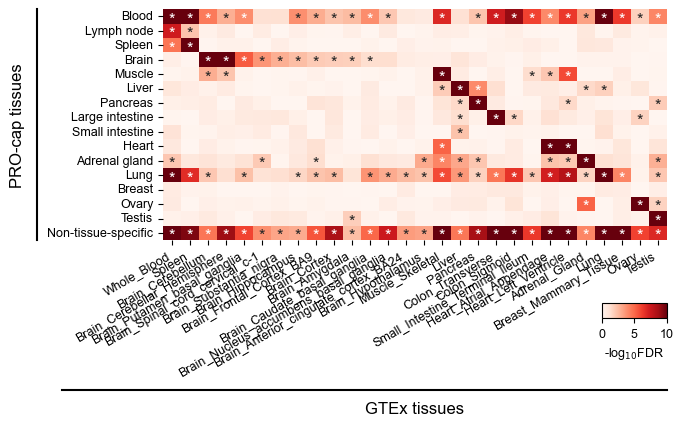

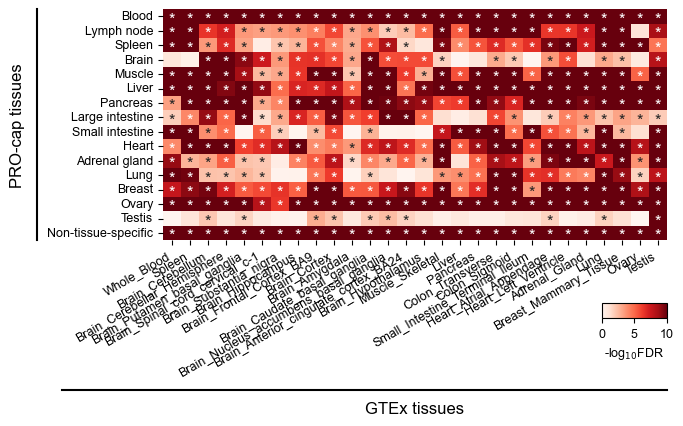

In [64]:
for d in ds:
	figN = "a" if d == "distal" else "b"
	outputfile = f"{PROJECT_DIR_o2}figures/ExtDataFig7{figN}.pdf"
	heatmap(df_fdr[d][order], outputfile)